<a href="https://colab.research.google.com/github/lifelonglearnerit/keras_tuner/blob/main/keras_tuner_balanced_batch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Balanced Batch Generator for Tensorflow models
Exploration of the applications of balanced batch generator to imbalanced classfication problems

In [ ]:
# eda necessary 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import datetime as dt
import re 
import random 
from ipywidgets import widgets
from pandas_profiling import ProfileReport


# modeling 
import numpy
import matplotlib.pyplot  as plt
import pandas as pd
import time
import random 
from pandas import read_csv
from pandas import set_option
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer 

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score 
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from numpy import average
from numpy import where
from collections import Counter 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.metrics import AUC
from tensorflow.keras.metrics import Recall
from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import TruePositives
from tensorflow.keras.metrics import TrueNegatives
from tensorflow.keras.metrics import FalsePositives
from tensorflow.keras.metrics import FalseNegatives
from tensorflow.keras.metrics import PrecisionAtRecall
from tensorflow.keras.metrics import SensitivityAtSpecificity
from tensorflow.keras.metrics import SpecificityAtSensitivity
from tensorflow.keras import Model

from tensorflow.keras.callbacks import EarlyStopping


import keras_tuner as kt
from keras_tuner.tuners import Hyperband
from keras_tuner.tuners import RandomSearch
from keras_tuner.tuners import BayesianOptimization
from keras_tuner import Objective, HyperParameters

In [ ]:
import copy 
# parameters template with default settings 
PARAMETERS = {
    'RandomSearch': {
                    'hypermodel': None,
                    'objective': None,
                    'max_trials': 10,
                    'seed': None,
                    'project_name': None
        },
        
    'Hyperband': {
                    'hypermodel': None, 
                    'objective': None, 
                    'max_epochs': 100, 
                    'factor': 3, 
                    'hyperband_iterations': 1, 
                    'seed': None, 
                    'project_name': None
        },
    'BayesianOptimization': {
                    'hypermodel':None,
                    'objective':None,
                    'max_trials':10,
                    'num_initial_points':2,
                    'alpha':0.0001,
                    'beta':2.6,
                    'seed':None,
                    'project_name': None
        },

                 
    'search_param': {
            'x':None,
            'y':None,
            'batch_size':None,
            'epochs':1,
            'verbose':'auto',
            'callbacks': None,
            'validation_split': 0.0,
            'validation_data':None,
            'shuffle':True,
            'class_weight':None,
            'sample_weight':None,
            'initial_epoch':0,
            'steps_per_epoch':None,
            'validation_steps':None,
            'validation_batch_size':None,
            'validation_freq':1,
            'max_queue_size':10,
            'workers': 1,
            'use_multiprocessing': False
        },
    
    'return_param': {
        'num_trials': 1,
        'num_models': 5,
        'num_trials_summary': 5
        }

    }
def make_parameters():
    return copy.deepcopy(PARAMETERS)

In [ ]:
import time
from functools import wraps

def timeit(f):
    @wraps(f)
    def wrapper(*args, **kwds):
        start_time = time.time()
        result = f(*args, **kwds)
        elapsed_time = time.time() - start_time
        print(f"Elapsed computation time: {elapsed_time:.3f} secs")
        return (elapsed_time, result)

    return wrapper

def prepare_data(data: pd.DataFrame,
                 test_size: float):
    
    last_col = list(data.columns)[-1]
    features = data.drop(labels=(last_col), axis=1)
    labels   = data[last_col]
    
    X_train_all, X_val_all, y_train, y_val  = train_test_split(
        features, labels, test_size=test_size, random_state=42, 
        stratify=labels
        )
    
    return [X_train_all, X_val_all, y_train, y_val, features, labels]

def transform_data(features, labels): 
    cat_cols = features.select_dtypes(include=['object', 'bool']).columns
    num_cols = features.select_dtypes(include=['int64', 'float64']).columns
    labels = LabelEncoder().fit_transform(labels)
    preprocesor = ColumnTransformer(
        [('c', OneHotEncoder(), cat_cols), 
         ('s', StandardScaler(), num_cols)],
         remainder="passthrough",
         sparse_threshold=0
        )
    features = preprocesor.fit_transform(features)
    return features, labels 

def weight_heuristic(training_labels: numpy.array) -> dict: 
    weights = dict()
    """Heuristic for generating class weights for imbalanced classification
    based on : https://gking.harvard.edu/files/0s.pdf
    class weight = number of rows / (number of classes * number of class members)
    
    Parameters
    ----------
    training_labels : numpy.arrary
        An array of labels for binary classification problem

    Returns
    -------
    dict
        A dictionary with weights for each class:
        {0: weight, 1: weight}
    """
    n_samples = training_labels.shape[0]
    n_neg_samp, n_pos_samp = np.bincount(training_labels)
    
    weights[0] = n_samples / (2 * n_neg_samp)
    weights[1] = n_samples / (2 * n_pos_samp)

    return weights
    


def dynamic_builder(hp: HyperParameters) -> Model:
    METRICS = [
        AUC(curve="ROC", name="auc"),
        AUC(curve="PR", name="pr"),
        Precision(name='precision'),
        Recall(name='recall'),
        TruePositives(name='tp'),
        FalsePositives(name='fp'),
        TrueNegatives(name='tn'),
        FalseNegatives(name='fn'),
            ]

    
    model = keras.Sequential()

    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(
            keras.layers.Dense(
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(keras.layers.Dropout(rate=hp.Choice("drop", [0.2, 0.3, 0.5])))
        
    model.add(keras.layers.Dense(1, activation="sigmoid"))
    
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    
    optimizers_dict = {
        "Adam":    Adam(learning_rate=learning_rate, name="Adam"),
        "SGD":     SGD(learning_rate=learning_rate, name="SGD"),
        "Adagrad": Adagrad(learning_rate=learning_rate, name="Adagrad")
        }
    
    hp_optimizers = hp.Choice('optimizer', ["Adam", "Adagrad"])
    
    model.compile(
        optimizer=optimizers_dict[hp_optimizers],
        loss="binary_crossentropy",
        metrics=METRICS,
        )
    return model



@timeit
def multi_tuner(tuner: 'str',
                params: dict) -> tuple: 
    """Initiates search for Hyperparameters for neural network 
    with specified search algorithm and arguments 

    Parameters
    ----------
    tuner : str
        A string denoting name of the search algorithm which 
        will be used
    params: dict
        A dictionary with arguments for search algoritm and 
        keras

    Returns
    -------
    tuple
        A tuple with parameters in format:
        (best hyperparameters, list(specified number of best models))
    """
    
    
    dict_tuners = {
        'RandomSearch'        : kt.RandomSearch(**params['RandomSearch']),
        'Hyperband'           : kt.Hyperband(**params['Hyperband']),
        'BayesianOptimization': kt.BayesianOptimization(**params['BayesianOptimization'])
    }
    

    multi_tuner   = dict_tuners[tuner]
    
    
    if type(params['search_param']) == tuple:
        balanced_generator = params['search_param'][0]
        print('balanced_generator', balanced_generator)
        args_parameters    = params['search_param'][1]
        print('args_parameters', args_parameters)
        multi_search  = multi_tuner.search(balanced_generator, **args_parameters)
    else: 
        print('dlaczego tu FFS')
        multi_search  = multi_tuner.search(**params['search_param'])
        
    multi_best_hp = multi_tuner.get_best_hyperparameters(
                                    num_trials=params['return_param'].get('num_trials', 1))[0]
    multi_best_models = multi_tuner.get_best_models(
                                    num_models=params['return_param'].get('num_models', 5))
    

    if params['return_param'].get('num_trials_summary', 0) > 0:
        multi_tuner.results_summary(num_trials=params.get('num_trials_summary', 0))
    
    
    return multi_best_hp, multi_best_models



def generator_to_search(parameters: tuple) -> tuple:
    """Prepares tuple with arguments for non-keyword and keyword 
    parameters of keras.tuner.search method 

    Parameters
    ----------
    parameters : tuple
        A tuple with following order:
        (generator, epochs, steps_per_epoch, class_weight)

    Returns
    -------
    tuple
        A tuple with parameters in format:
        (non-keyword, {keyword})
    """
    
    generator       = parameters[0]
    epochs     = parameters[1]
    steps_per_epoch = parameters[2]
    class_weight    = parameters[3]
    
    return (
        generator, 
            {
            'epochs': epochs,
            'steps_per_epoch': steps_per_epoch,
            'class_weight': class_weight,
            }
        )

@timeit
def run_multi_tuners(tuners: list, parameters: dict) -> dict:
    """Iteratively invokes multituner_function for different 
    search algorithms

    Parameters
    ----------
    tuners : list
        A list of the search algorithm names 
    parameters : dict
        A dictionary containing parameters necessary to start 
        tuning process of keras tuner 

    Returns
    -------
    dict
        a dictionary of results from multi_tuner 
        key: name of the algoirthm
        value: (time, (time {ulti_best_hp, multi_best_models}))
    """
    results = dict()
    for alg in tuners: 
        print(f'Hyperparameters search with {alg} initiated')
        results[alg] = multi_tuner(alg, parameters)
        print(results[alg])
    return results 


def multi_results(tuners: list, results: tuple):
    """Prints results of the muli_tuner function

    Parameters
    ----------
    tuners : list
        A list of the search algorithm names 
    results : tuple
        results from multi_tuner function 

    """
    
    print(f'Hyperparameter search for {tuners}\ncompleted in {results[0]} sec')
    for model in tuners:
        print(f'\n========= {model} =========')
        print(f'Search completed in {results[1][model][0]} sec')
        for hp, val in results[1][model][1][0].values.items():
            
            print(f'{hp}: {val}')
            
            
def best_models_retraining(
                multituner_results: tuple,
                train_data: list,
                param: dict
                ): 
    
    trained_models   = dict()
    retrained_models = dict()
    
    mtr = multituner_results 
    search_algorithms_names = mtr[1].keys()
    
    for idx, algorithm in enumerate(search_algorithms_names):
        print(f'Training of the model with best HP from {algorithm} search')
        best_model = mtr[1][algorithm][1][1][0]
        print(best_model)
        print(train_data[0].shape)
        print(train_data[1].shape)
        if param.get('generator', 0) != 0:
            generator = param.get('generator', 0),
            history = best_model.fit(
                                *generator,
                                epochs=param.get('epochs', 50), 
                                verbose=param.get('verbose', 2), 
                                batch_size=param.get('batch_size', 32),
                                validation_split=param.get('validation_split', 0.1),
                                steps_per_epoch=param.get('steps_per_epoch', 7)
                                )           
        else:
            history = best_model.fit(
                                train_data[0], 
                                train_data[1], 
                                epochs=param.get('epochs', 50), 
                                verbose=param.get('verbose', 2), 
                                batch_size=param.get('batch_size', 32),
                                validation_split=param.get('validation_split', 0.1)
                                )
        
        metric = param.get('metric', 'pr') 
        best_epoch = history.history[metric].index(max(history.history[metric])) + 1
        print(f'Model #{idx} fit finished with best {metric}: {max(history.history[metric])} in epoch: {best_epoch}\n')
        trained_models[idx] = [best_model, history, best_epoch]
    
    for elements in trained_models.items():
        print(f'Retraining of the model #{elements[0]}')
        model = elements[1][0]
        best_train_epoch = elements[1][2]
        retrained_history = model.fit(
                                train_data[0], 
                                train_data[1], 
                                epochs=best_train_epoch,
                                verbose=param.get('verbose', 2), 
                                batch_size=param.get('batch_size', 32)
                               )
        retrained_models[elements[0]] = [model, retrained_history]
    
    return trained_models, retrained_models
        
    
def model_evaluate(model: keras.Model, 
                   test_data: list,
                   params: dict) -> dict:
    print('Evaluating on test data')
    batch = params.get('batch_size', 32)
    
    results = model.evaluate(
                    test_data[0], 
                    test_data[1], 
                    batch_size=batch
                    )
    return results

In [ ]:
from numpy import mean
from sklearn.datasets import make_classification


# generate dataset
X, y = make_classification(n_samples=100000, n_features=2, n_redundant=0,
n_clusters_per_class=2, weights=[0.95], flip_y=0, random_state=84)


Counter({0: 95000, 1: 5000})


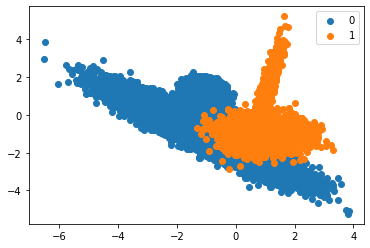

In [ ]:
%matplotlib inline 
from collections import Counter
from matplotlib import pyplot
from numpy import where


# summarize class distribution

counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = where(y == label)[0]
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42,
                                                    stratify=y)

In [ ]:
from imblearn.keras import balanced_batch_generator, BalancedBatchGenerator
from imblearn.under_sampling import NearMiss
# train_labels_g = tensorflow.keras.utils.to_categorical(train_labels, 2)
training_generator, steps_epoch = balanced_batch_generator(
    X_train, y_train, sampler=NearMiss(), batch_size=100, random_state=42
    )

In [ ]:
# copy of the parameter template 
multi_parameters = make_parameters()


# early stopping instance
early_stop = EarlyStopping(monitor='pr',patience=5)

# defining parameters of the RandomSearch tuner 
multi_parameters['RandomSearch']['hypermodel']   = dynamic_builder
multi_parameters['RandomSearch']['objective']    = Objective('pr', direction='max')
multi_parameters['RandomSearch']['max_trials']   = 20
multi_parameters['RandomSearch']['seed']         = 42
multi_parameters['RandomSearch']['project_name'] = 'change1'
multi_parameters['RandomSearch']['directory']    = "change_"
                         
# defining parameters of the Hyperband tuner 
multi_parameters['Hyperband']['hypermodel']   = dynamic_builder
multi_parameters['Hyperband']['objective']    = Objective('pr', direction='max')
multi_parameters['Hyperband']['max_epochs']   = 20
multi_parameters['Hyperband']['seed']         = 42
multi_parameters['Hyperband']['project_name'] = 'change2'
multi_parameters['Hyperband']['directory']    = "change_"

# defining parameters of the BayesianOptimization tuner 
multi_parameters['BayesianOptimization']['hypermodel']   = dynamic_builder
multi_parameters['BayesianOptimization']['objective']    = Objective('pr', direction='max')
multi_parameters['BayesianOptimization']['max_trials']   = 20
multi_parameters['BayesianOptimization']['seed']         = 42
multi_parameters['BayesianOptimization']['project_name'] = 'change3'
multi_parameters['BayesianOptimization']['directory']    = "change_"

# defining search parameters 
bb_generator = training_generator
epochs = 50
steps_per_epoch = 7
class_weight = None
generator_search = (bb_generator, epochs, steps_per_epoch, class_weight)
multi_parameters['search_param'] = generator_to_search(generator_search)


In [ ]:
tuners_list = ['RandomSearch', 'Hyperband', 'BayesianOptimization']
multituners_results = run_multi_tuners(tuners_list, multi_parameters)

Trial 20 Complete [00h 00m 05s]
pr: 0.9868608713150024

Best pr So Far: 0.9878972172737122
Total elapsed time: 00h 02m 30s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in change_\change3
Showing 0 best trials
Elapsed computation time: 151.480 secs
(151.47964215278625, (<keras_tuner.engine.hyperparameters.HyperParameters object at 0x0000024BC6353370>, [<tensorflow.python.keras.engine.sequential.Sequential object at 0x0000024BC21AFE80>, <tensorflow.python.keras.engine.sequential.Sequential object at 0x0000024BC4D35310>, <tensorflow.python.keras.engine.sequential.Sequential object at 0x0000024BC3A62730>, <tensorflow.python.keras.engine.sequential.Sequential object at 0x0000024BC6546310>, <tensorflow.python.keras.engine.sequential.Sequential object at 0x0000024BCB6B0EE0>]))
Elapsed computation time: 358.352 secs


In [ ]:
multi_results(tuners_list, multituners_results)

Hyperparameter search for ['RandomSearch', 'Hyperband', 'BayesianOptimization']
completed in 358.35162568092346 sec

========= RandomSearch =========
Search completed in 99.91610264778137 sec
num_layers: 3
units_0: 224
activation: relu
dropout: False
lr: 0.0025890919266874407
optimizer: Adagrad
units_1: 512
units_2: 128
units_3: 320
drop: 0.3

========= Hyperband =========
Search completed in 106.95476770401001 sec
num_layers: 2
units_0: 384
activation: tanh
dropout: False
lr: 0.0036569295366168696
optimizer: Adagrad
units_1: 192
units_2: 416
units_3: 256
drop: 0.2
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0019

========= BayesianOptimization =========
Search completed in 151.47964215278625 sec
num_layers: 5
units_0: 32
activation: relu
dropout: True
lr: 0.0025278863265980945
optimizer: Adam
units_1: 512
units_2: 32
units_3: 512
drop: 0.2
units_4: 352


In [ ]:
p_dict = {'batch_size': 100,  'validation_split': None, 'generator': bb_generator}
trained, retrained = best_models_retraining(multituners_results, [X_train, y_train], p_dict)

Training of the model with best HP from RandomSearch search
(80000, 2)
(80000,)
Epoch 1/50
7/7 - 2s - loss: 0.4714 - auc: 0.9676 - pr: 0.9749 - precision: 0.9962 - recall: 0.7551 - tp: 259.0000 - fp: 1.0000 - tn: 356.0000 - fn: 84.0000
Epoch 2/50
7/7 - 0s - loss: 0.4624 - auc: 0.9712 - pr: 0.9797 - precision: 1.0000 - recall: 0.7529 - tp: 259.0000 - fp: 0.0000e+00 - tn: 356.0000 - fn: 85.0000
Epoch 3/50
7/7 - 0s - loss: 0.4522 - auc: 0.9695 - pr: 0.9781 - precision: 1.0000 - recall: 0.7880 - tp: 275.0000 - fp: 0.0000e+00 - tn: 351.0000 - fn: 74.0000
Epoch 4/50
7/7 - 0s - loss: 0.4484 - auc: 0.9644 - pr: 0.9780 - precision: 1.0000 - recall: 0.8028 - tp: 285.0000 - fp: 0.0000e+00 - tn: 345.0000 - fn: 70.0000
Epoch 5/50
7/7 - 0s - loss: 0.4495 - auc: 0.9596 - pr: 0.9705 - precision: 1.0000 - recall: 0.7568 - tp: 252.0000 - fp: 0.0000e+00 - tn: 367.0000 - fn: 81.0000
Epoch 6/50
7/7 - 0s - loss: 0.4315 - auc: 0.9713 - pr: 0.9821 - precision: 1.0000 - recall: 0.8189 - tp: 294.0000 - fp: 0.00

Epoch 1/50
7/7 - 2s - loss: 0.4065 - auc: 0.9635 - pr: 0.9770 - precision: 1.0000 - recall: 0.7624 - tp: 276.0000 - fp: 0.0000e+00 - tn: 338.0000 - fn: 86.0000
Epoch 2/50
7/7 - 0s - loss: 0.3754 - auc: 0.9823 - pr: 0.9869 - precision: 1.0000 - recall: 0.7778 - tp: 273.0000 - fp: 0.0000e+00 - tn: 349.0000 - fn: 78.0000
Epoch 3/50
7/7 - 0s - loss: 0.3725 - auc: 0.9609 - pr: 0.9760 - precision: 1.0000 - recall: 0.7695 - tp: 267.0000 - fp: 0.0000e+00 - tn: 353.0000 - fn: 80.0000
Epoch 4/50
7/7 - 0s - loss: 0.3551 - auc: 0.9717 - pr: 0.9818 - precision: 1.0000 - recall: 0.7737 - tp: 277.0000 - fp: 0.0000e+00 - tn: 342.0000 - fn: 81.0000
Epoch 5/50
7/7 - 0s - loss: 0.3677 - auc: 0.9554 - pr: 0.9662 - precision: 1.0000 - recall: 0.7305 - tp: 244.0000 - fp: 0.0000e+00 - tn: 366.0000 - fn: 90.0000
Epoch 6/50
7/7 - 0s - loss: 0.3608 - auc: 0.9553 - pr: 0.9701 - precision: 0.9928 - recall: 0.7631 - tp: 277.0000 - fp: 2.0000 - tn: 335.0000 - fn: 86.0000
Epoch 7/50
7/7 - 0s - loss: 0.3396 - auc: 0.

Epoch 2/50
7/7 - 0s - loss: 0.1903 - auc: 0.9755 - pr: 0.9820 - precision: 0.9527 - recall: 0.9045 - tp: 322.0000 - fp: 16.0000 - tn: 328.0000 - fn: 34.0000
Epoch 3/50
7/7 - 0s - loss: 0.2617 - auc: 0.9502 - pr: 0.9659 - precision: 0.9530 - recall: 0.8468 - tp: 304.0000 - fp: 15.0000 - tn: 326.0000 - fn: 55.0000
Epoch 4/50
7/7 - 0s - loss: 0.1757 - auc: 0.9724 - pr: 0.9787 - precision: 0.9582 - recall: 0.9283 - tp: 298.0000 - fp: 13.0000 - tn: 366.0000 - fn: 23.0000
Epoch 5/50
7/7 - 0s - loss: 0.2008 - auc: 0.9669 - pr: 0.9772 - precision: 0.9632 - recall: 0.8920 - tp: 314.0000 - fp: 12.0000 - tn: 336.0000 - fn: 38.0000
Epoch 6/50
7/7 - 0s - loss: 0.1858 - auc: 0.9654 - pr: 0.9776 - precision: 0.9669 - recall: 0.9042 - tp: 321.0000 - fp: 11.0000 - tn: 334.0000 - fn: 34.0000
Epoch 7/50
7/7 - 0s - loss: 0.1879 - auc: 0.9639 - pr: 0.9759 - precision: 0.9772 - recall: 0.8876 - tp: 300.0000 - fp: 7.0000 - tn: 355.0000 - fn: 38.0000
Epoch 8/50
7/7 - 0s - loss: 0.1989 - auc: 0.9615 - pr: 0.97

Epoch 4/41
800/800 - 2s - loss: 0.0336 - auc: 0.9912 - pr: 0.9515 - precision: 0.9812 - recall: 0.8235 - tp: 3294.0000 - fp: 63.0000 - tn: 75937.0000 - fn: 706.0000
Epoch 5/41
800/800 - 2s - loss: 0.0316 - auc: 0.9917 - pr: 0.9550 - precision: 0.9829 - recall: 0.8325 - tp: 3330.0000 - fp: 58.0000 - tn: 75942.0000 - fn: 670.0000
Epoch 6/41
800/800 - 3s - loss: 0.0301 - auc: 0.9919 - pr: 0.9575 - precision: 0.9847 - recall: 0.8385 - tp: 3354.0000 - fp: 52.0000 - tn: 75948.0000 - fn: 646.0000
Epoch 7/41
800/800 - 2s - loss: 0.0289 - auc: 0.9921 - pr: 0.9596 - precision: 0.9846 - recall: 0.8453 - tp: 3381.0000 - fp: 53.0000 - tn: 75947.0000 - fn: 619.0000
Epoch 8/41
800/800 - 2s - loss: 0.0279 - auc: 0.9925 - pr: 0.9611 - precision: 0.9841 - recall: 0.8503 - tp: 3401.0000 - fp: 55.0000 - tn: 75945.0000 - fn: 599.0000
Epoch 9/41
800/800 - 2s - loss: 0.0272 - auc: 0.9921 - pr: 0.9619 - precision: 0.9833 - recall: 0.8555 - tp: 3422.0000 - fp: 58.0000 - tn: 75942.0000 - fn: 578.0000
Epoch 10/4

Epoch 10/32
800/800 - 4s - loss: 0.0243 - auc: 0.9921 - pr: 0.9626 - precision: 0.9620 - recall: 0.8915 - tp: 3566.0000 - fp: 141.0000 - tn: 75859.0000 - fn: 434.0000
Epoch 11/32
800/800 - 4s - loss: 0.0240 - auc: 0.9917 - pr: 0.9642 - precision: 0.9598 - recall: 0.8953 - tp: 3581.0000 - fp: 150.0000 - tn: 75850.0000 - fn: 419.0000
Epoch 12/32
800/800 - 4s - loss: 0.0243 - auc: 0.9921 - pr: 0.9637 - precision: 0.9629 - recall: 0.8945 - tp: 3578.0000 - fp: 138.0000 - tn: 75862.0000 - fn: 422.0000
Epoch 13/32
800/800 - 4s - loss: 0.0242 - auc: 0.9913 - pr: 0.9638 - precision: 0.9633 - recall: 0.8932 - tp: 3573.0000 - fp: 136.0000 - tn: 75864.0000 - fn: 427.0000
Epoch 14/32
800/800 - 4s - loss: 0.0240 - auc: 0.9918 - pr: 0.9639 - precision: 0.9644 - recall: 0.8947 - tp: 3579.0000 - fp: 132.0000 - tn: 75868.0000 - fn: 421.0000
Epoch 15/32
800/800 - 4s - loss: 0.0240 - auc: 0.9924 - pr: 0.9645 - precision: 0.9657 - recall: 0.8873 - tp: 3549.0000 - fp: 126.0000 - tn: 75874.0000 - fn: 451.000

In [ ]:
multituners_results

(358.35162568092346,
 {'RandomSearch': (99.91610264778137,
   (<keras_tuner.engine.hyperparameters.HyperParameters at 0x24bc63536a0>,
     <tensorflow.python.keras.engine.sequential.Sequential at 0x24bc0df27f0>])),
  'Hyperband': (106.95476770401001,
   (<keras_tuner.engine.hyperparameters.HyperParameters at 0x24bc6997070>,
     <tensorflow.python.keras.engine.sequential.Sequential at 0x24bc22c06d0>])),
  'BayesianOptimization': (151.47964215278625,
   (<keras_tuner.engine.hyperparameters.HyperParameters at 0x24bc6353370>,
     <tensorflow.python.keras.engine.sequential.Sequential at 0x24bcb6b0ee0>]))})

In [ ]:
rand_model = dynamic_builder(multituners_results[1]['RandomSearch'][1][0])
y_hat = rand_model.predict(X_test)
confusion_matrix(y_test, y_hat > 0.5)
# random_eval = best_random.predict(X_test)

array([[15426,  3574],
       [  546,   454]], dtype=int64)

In [ ]:
rand_model = multituners_results[1]['RandomSearch'][1][1][0]
y_hat = rand_model.predict(X_test)
confusion_matrix(y_test, y_hat > 0.5)
# random_eval = best_random.predict(X_test)

array([[18962,    38],
       [  120,   880]], dtype=int64)

In [ ]:
dic =  {'gen': 0}
dic1 = {'gen': bb_generator}
dic2 = {}

In [ ]:
test = dic.get('gen', 0)
test1 = dic1.get('gen', 0)
test2 = dic2.get('gen', 0)
print(f"test: {test != 0}, test: {test1 != 0}, test: {test2 != 0}")

test: False, test: True, test: False
